# Training and validating on realistic data

In this notebook we generate a realistic simulation of the UNIONS/CFIS survey. Then we use it to creat a PSF model using the the MCCD algorithm.

Note that by default the generated dataset is noiseless. In this test we haven't added noise to the observed stars.


In [5]:
import numpy as np
import mccd.auxiliary_fun as mccd_aux
import mccd
from astropy.io import fits

import random

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap, LinearSegmentedColormap


In [6]:
plt.rc('text', usetex=True)
font = {'family' : 'serif',
        'weight' : 'bold',
        'size'   : 20}
mpl.rc('font', **font)

plot_style = {
                'figure.figsize': (6,6),
                'figure.dpi': 100,
                'figure.autolayout':True,
                'lines.linewidth': 4,
                'lines.linestyle': '-',
                'lines.marker': 'o',
                'lines.markersize': 10,
                'legend.fontsize': 20,
                'legend.loc': 'best',
                'axes.titlesize': 24,
                'axes.grid': False,
                'axes.grid.which': 'major',
                'axes.grid.axis': 'both'}
mpl.rcParams.update(plot_style)

def plot_fun(star_img, cmap='gist_stern'):
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    im1 = ax1.imshow(star_img, interpolation='None',cmap=cmap)
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(im1, cax=cax, extend='both')
    cbar.minorticks_on()
    fig.tight_layout()
    ax1.set_xticks([]);ax1.set_yticks([])
    ax1.axis('off')
    plt.show()

loc2glob = mccd.mccd_utils.Loc2Glob()

# Pre-defined colormap
top = mpl.cm.get_cmap('Oranges_r', 128)
bottom = mpl.cm.get_cmap('Blues', 128)
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
newcmp = ListedColormap(newcolors, name='OrangeBlue')

def plot_ccds_fun(positions,mom,title):
    fig = plt.figure(figsize=(8, 8))
    ax1 = fig.add_subplot(111)
    for ccd_it in range(40):
        xs,ys = loc2glob.shift_coord(ccd_it)
        rect = mpl.patches.Rectangle((xs,ys),2048,4612,linewidth=1,edgecolor='r',facecolor='none')
        ax1.add_patch(rect)

    im1 = ax1.scatter(positions[:, 0], positions[:, 1], s=5,c=mom, marker='*', cmap=newcmp)
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im1, cax=cax, orientation='vertical')
    ax1.set_xticks([]);ax1.set_yticks([])
    ax1.axis('off')
    ax1.set_title(title)
    plt.show()


# Generate the realistic dataset




In [14]:
# Define data paths

e1_path = './../data/sim_inputs/e1_psf.npy'
e2_path = './../data/sim_inputs/e2_psf.npy'
fwhm_path = './../data/sim_inputs/seeing_distribution.npy'
dataset_path = './../data/realistic_dataset/input_dataset/'
cat_id = 1000000


In [4]:
# Generate exposure with an atmospheric realisation
sim_dataset_gen = mccd.dataset_generation.GenerateRealisticDataset(
    e1_path=e1_path,
    e2_path=e2_path,
    size_path=fwhm_path,
    output_path=dataset_path,
    catalog_id=cat_id)




Mean FWHM:  [0.68144129]


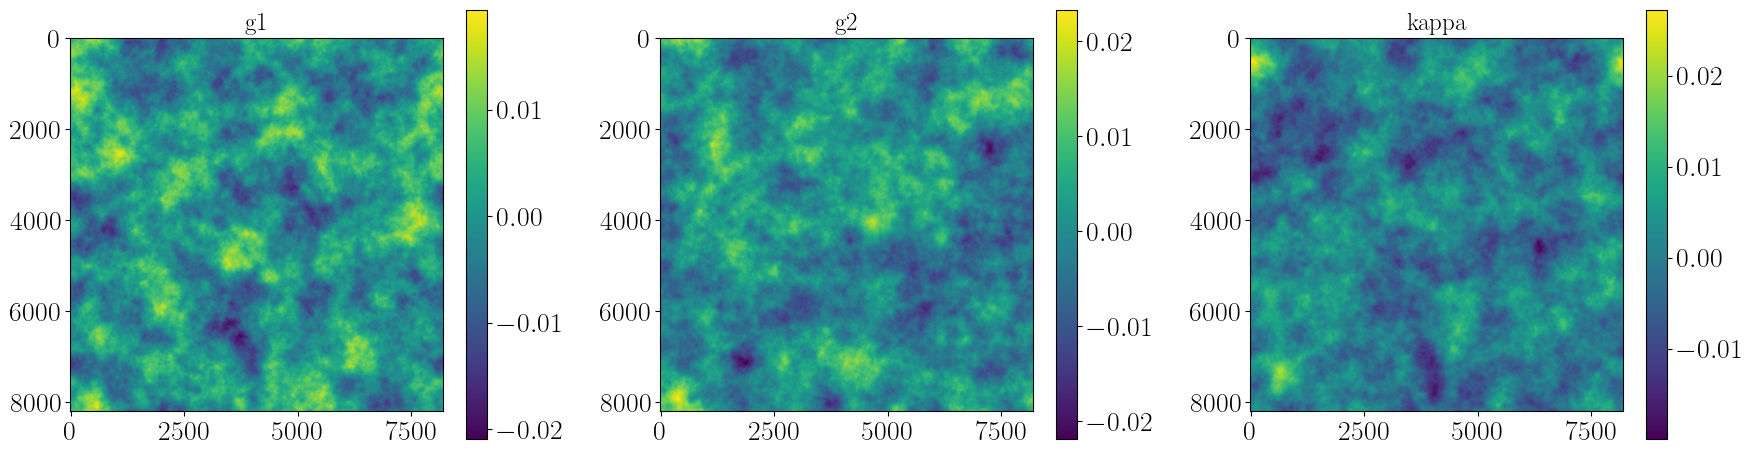

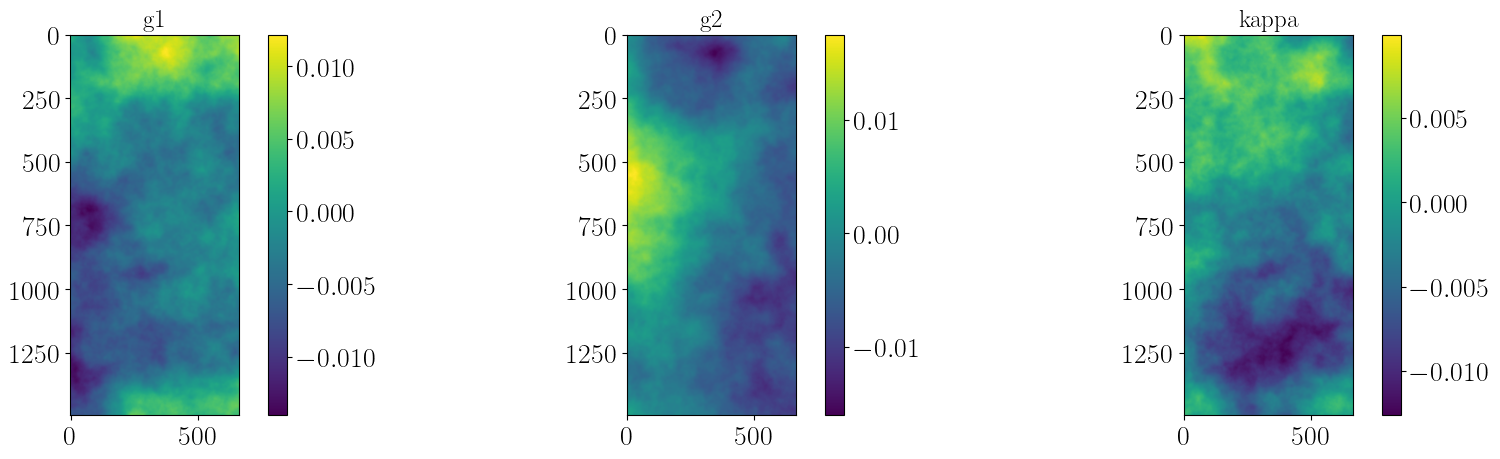

kmin:  0.00013293211516366451
kmax:  54.44899437103699


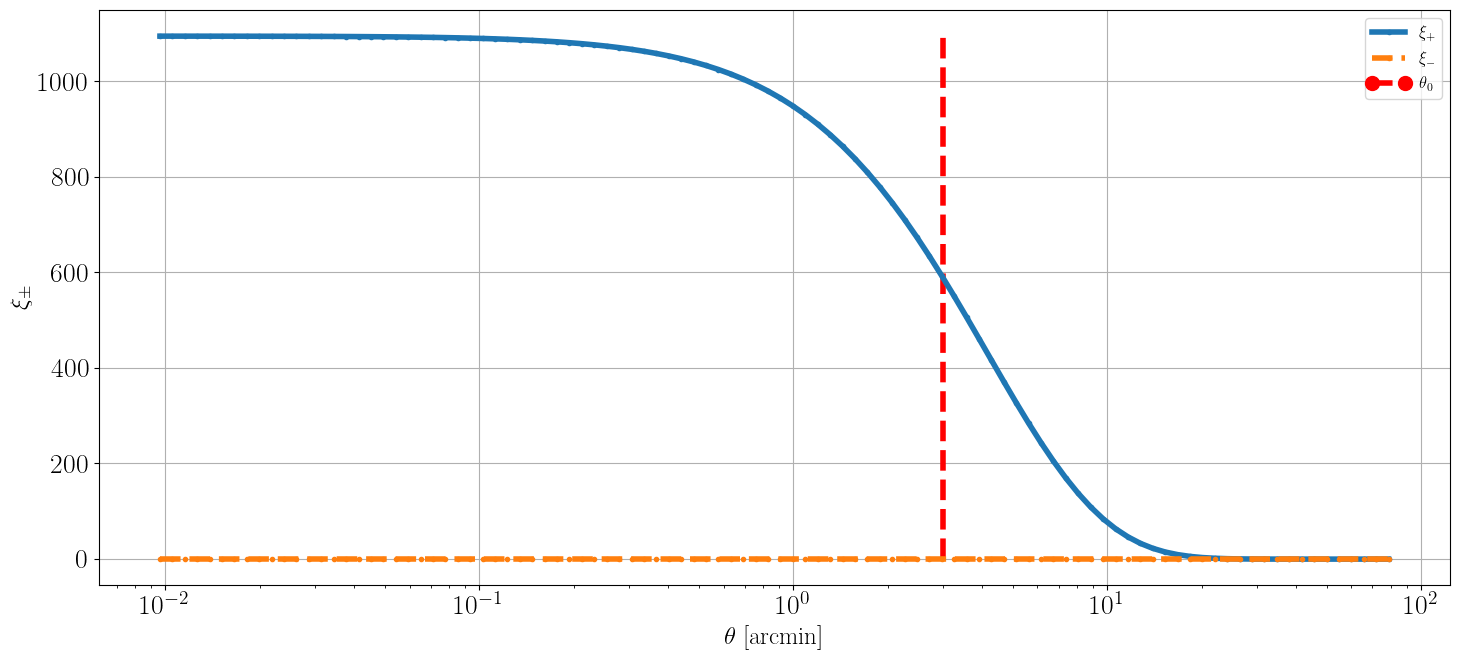

In [5]:
# Check the mean FWHM
print('Mean FWHM: ',sim_dataset_gen.exposure_sim.mean_fwhm)

# Check the atmosphere realisation
sim_dataset_gen.exposure_sim.atmosphere.plot_realisation()

# Check the atmosphere correlation function
sim_dataset_gen.exposure_sim.atmosphere.plot_correlation()



In [6]:
# Generate the train and the test datasets
sim_dataset_gen.generate_train_data()
sim_dataset_gen.generate_test_data()


# Check the output catalog

In [8]:
train_cat_path = dataset_path + 'train_star_selection-1000000.fits'

train_cat = fits.open(train_cat_path)[1]


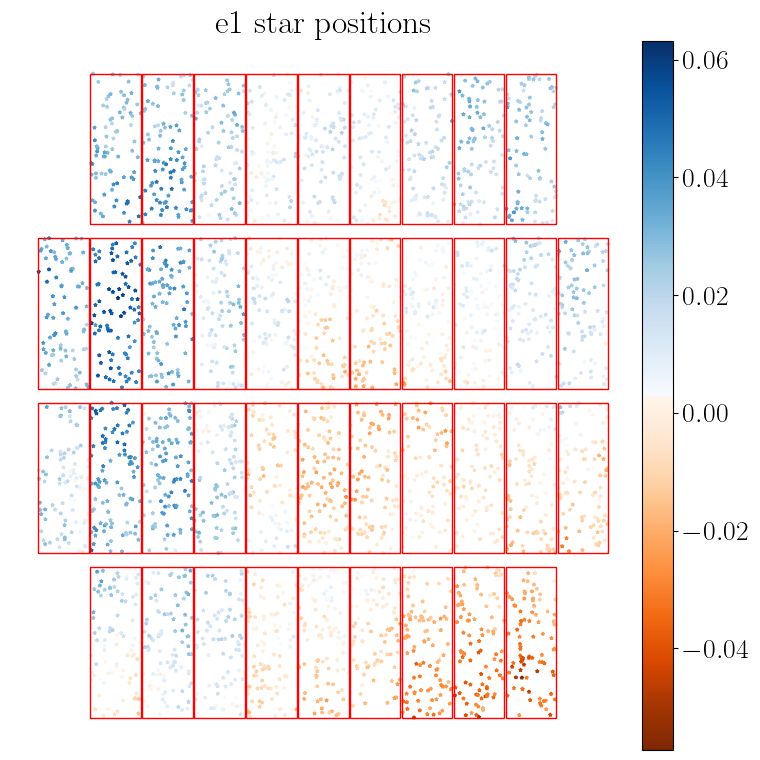

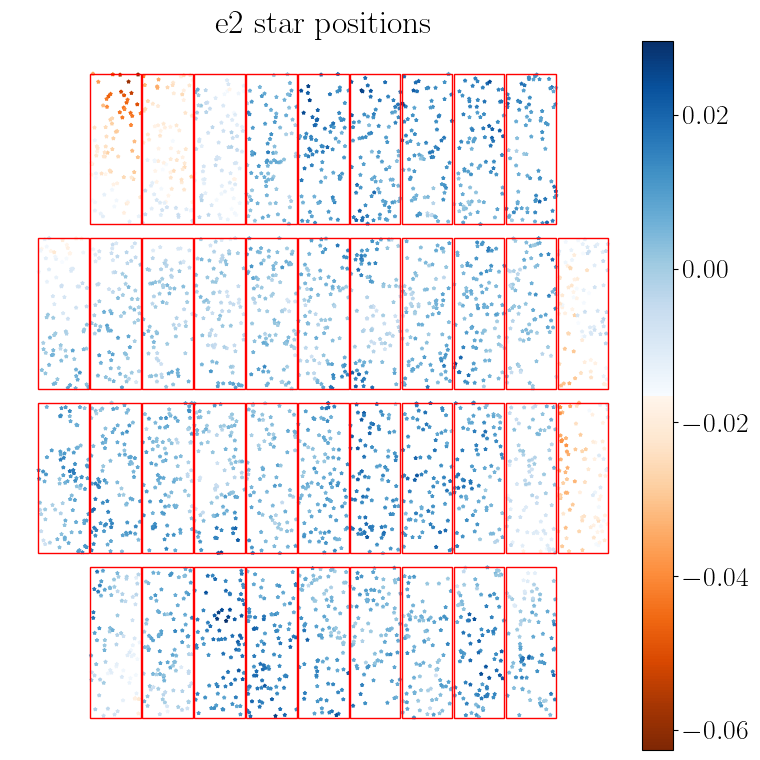

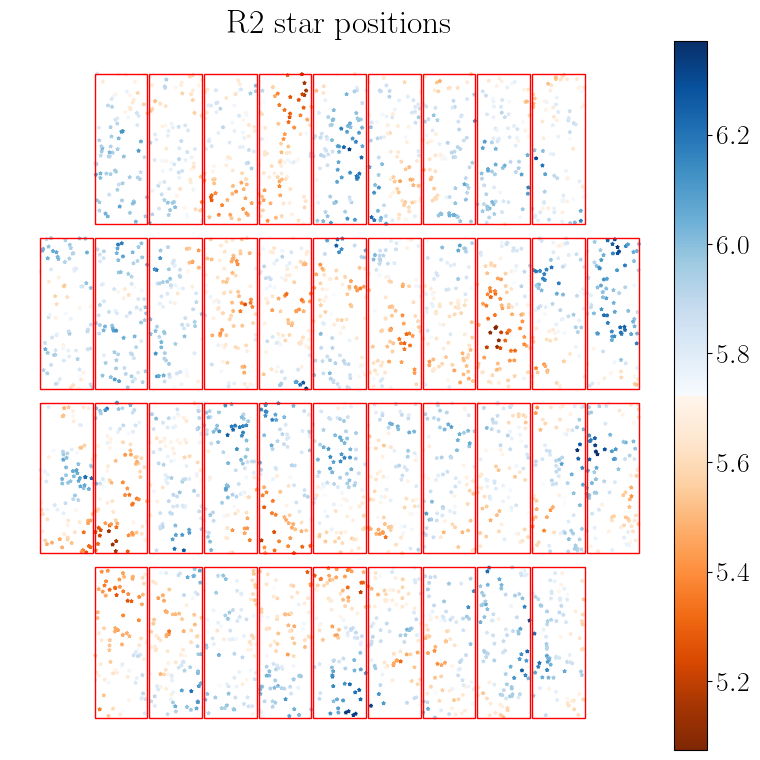

In [9]:
pos = train_cat.data['GLOB_POSITION_IMG_LIST']
plot_ccds_fun(pos,train_cat.data['TRUE_E1_HSM'],'e1 star positions')
plot_ccds_fun(pos,train_cat.data['TRUE_E2_HSM'],'e2 star positions')
plot_ccds_fun(pos,2.*train_cat.data['TRUE_SIG_HSM']**2,'R2 star positions')


# Prepare the dataset for training

In [10]:
train_cat.columns


ColDefs(
    name = 'VIGNET_LIST'; format = '2601D'; dim = '(51, 51)'
    name = 'GLOB_POSITION_IMG_LIST'; format = '2D'; dim = '(2,)'
    name = 'MASK_LIST'; format = '2601D'; dim = '(51, 51)'
    name = 'CCD_ID_LIST'; format = '1D'
    name = 'TRUE_E1_HSM'; format = '1D'
    name = 'TRUE_E2_HSM'; format = '1D'
    name = 'TRUE_SIG_HSM'; format = '1D'
)

In [11]:
# Extract the data from the fits catalog 
positions = np.copy(train_cat.data['GLOB_POSITION_IMG_LIST'])
stars = np.copy(train_cat.data['VIGNET_LIST'])
ccds = np.copy(train_cat.data['CCD_ID_LIST']).astype(int)
ccds_unique = np.unique(np.copy(train_cat.data['CCD_ID_LIST'])).astype(int)
# Generate the masks
masks = mccd.utils.handle_SExtractor_mask(stars,thresh=-1e5)

# Generate the list format needed by the MCCD package
pos_list = [positions[ccds == ccd] for ccd in ccds_unique]
star_list = [mccd.utils.rca_format(stars[ccds == ccd]) for ccd in ccds_unique]
mask_list = [mccd.utils.rca_format(masks[ccds == ccd]) for ccd in ccds_unique]
ccd_list = [ccds[ccds == ccd].astype(int) for ccd in ccds_unique]
ccd_list = [np.unique(_list)[0].astype(int) for _list in ccd_list]
SNR_weight_list = None  # We wont use any weighting technique as the SNR is constant over the Field of View




# Let's train the model on these stars


In [20]:
# Parameters

# MCCD instance
n_comp_loc = 8 
d_comp_glob = 8
filters = None
ksig_loc = 0.0
ksig_glob = 0.0
d_hyb_loc = 2
min_d_comp_glob = None
ccd_star_thresh = -0.1
rmse_thresh = 1.25

# MCCD fit
psf_size = 6.15
psf_size_type = 'R2'
n_eigenvects = 5
n_iter_rca = 1
nb_iter_glob = 2 
nb_iter_loc = 2
nb_subiter_S_loc = 300
nb_subiter_A_loc = 400
nb_subiter_S_glob = 100
nb_subiter_A_glob = 200
loc_model = 'hybrid'


# Build the paramter dictionaries
mccd_inst_kw = {'n_comp_loc': n_comp_loc, 'd_comp_glob': d_comp_glob,
                'filters': filters,       'ksig_loc': ksig_loc,
                'ksig_glob':ksig_glob, 'd_hyb_loc': d_hyb_loc,
               'min_d_comp_glob': min_d_comp_glob, 'ccd_star_thresh': ccd_star_thresh,
               'rmse_thresh': rmse_thresh}

mccd_fit_kw = {'psf_size': psf_size,                  'psf_size_type':psf_size_type,
              'n_eigenvects': n_eigenvects,          'nb_iter':n_iter_rca,
              'nb_iter_glob':nb_iter_glob,           'nb_iter_loc':nb_iter_loc,
              'nb_subiter_S_loc':nb_subiter_S_loc,   'nb_subiter_A_loc':nb_subiter_A_loc,
              'nb_subiter_S_glob':nb_subiter_S_glob, 'nb_subiter_A_glob':nb_subiter_A_glob,
              'loc_model':loc_model}

output_path = './../data/realistic_dataset/trained_model/'



In [16]:

# Instanciate the class
mccd_instance = mccd.MCCD(**mccd_inst_kw, verbose=True)
# Launch the training
S, A_loc, A_glob, alpha, pi = mccd_instance.fit(star_list, pos_list, ccd_list, mask_list,
                                                SNR_weight_list, **mccd_fit_kw)



Running basic initialization tasks...
... Done.
Constructing local spatial constraint...


/Users/tliaudat/Documents/PhD/github/cosmostat_official/mccd_testing/mccd/mccd/utils.py:523: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  self.VT = np.vstack((eigenvect for eigenvect in list_eigenvects))


... Done.
Building position polynomials...
... Done.


100% (100 of 100) |######################| Elapsed Time: 0:09:10 Time:  0:09:10
100% (200 of 200) |######################| Elapsed Time: 0:07:46 Time:  0:07:46
100% (100 of 100) |######################| Elapsed Time: 0:09:10 Time:  0:09:10
100% (300 of 300) |######################| Elapsed Time: 0:00:48 Time:  0:00:48
100% (400 of 400) |######################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (300 of 300) |######################| Elapsed Time: 0:00:51 Time:  0:00:51
100% (400 of 400) |######################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (300 of 300) |######################| Elapsed Time: 0:00:50 Time:  0:00:50
100% (400 of 400) |######################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (300 of 300) |######################| Elapsed Time: 0:00:50 Time:  0:00:50
100% (400 of 400) |######################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (300 of 300) |######################| Elapsed Time: 0:00:50 Time:  0:00:50
100% (400 of 400) |#####################

 - Converged!


100% (300 of 300) |######################| Elapsed Time: 0:00:37 Time:  0:00:37
100% (400 of 400) |######################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (300 of 300) |######################| Elapsed Time: 0:00:50 Time:  0:00:50
100% (400 of 400) |######################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (300 of 300) |######################| Elapsed Time: 0:00:48 Time:  0:00:48
100% (400 of 400) |######################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (300 of 300) |######################| Elapsed Time: 0:00:49 Time:  0:00:49
100% (400 of 400) |######################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (300 of 300) |######################| Elapsed Time: 0:00:47 Time:  0:00:47
100% (400 of 400) |######################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (300 of 300) |######################| Elapsed Time: 0:00:51 Time:  0:00:51
100% (400 of 400) |######################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (300 of 300) |#####################

 - Converged!


100% (300 of 300) |######################| Elapsed Time: 0:00:53 Time:  0:00:53
100% (400 of 400) |######################| Elapsed Time: 0:00:06 Time:  0:00:06
100% (300 of 300) |######################| Elapsed Time: 0:00:52 Time:  0:00:52
100% (400 of 400) |######################| Elapsed Time: 0:00:06 Time:  0:00:06
100% (300 of 300) |######################| Elapsed Time: 0:00:48 Time:  0:00:48
100% (400 of 400) |######################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (300 of 300) |######################| Elapsed Time: 0:00:53 Time:  0:00:53
100% (400 of 400) |######################| Elapsed Time: 0:00:06 Time:  0:00:06
100% (300 of 300) |######################| Elapsed Time: 0:00:51 Time:  0:00:51
100% (400 of 400) |######################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (300 of 300) |######################| Elapsed Time: 0:00:48 Time:  0:00:48
100% (400 of 400) |######################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (300 of 300) |#####################

 - Converged!


100% (300 of 300) |######################| Elapsed Time: 0:00:40 Time:  0:00:40
100% (400 of 400) |######################| Elapsed Time: 0:00:06 Time:  0:00:06
100% (300 of 300) |######################| Elapsed Time: 0:00:47 Time:  0:00:47
100% (400 of 400) |######################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (300 of 300) |######################| Elapsed Time: 0:00:53 Time:  0:00:53
100% (400 of 400) |######################| Elapsed Time: 0:00:06 Time:  0:00:06
100% (300 of 300) |######################| Elapsed Time: 0:00:53 Time:  0:00:53
100% (400 of 400) |######################| Elapsed Time: 0:00:06 Time:  0:00:06
100% (300 of 300) |######################| Elapsed Time: 0:00:50 Time:  0:00:50
100% (400 of 400) |######################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (300 of 300) |######################| Elapsed Time: 0:00:51 Time:  0:00:51
100% (400 of 400) |######################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (300 of 300) |#####################

 - Converged!


100% (300 of 300) |######################| Elapsed Time: 0:00:14 Time:  0:00:14
 44% (134 of 300) |#########             | Elapsed Time: 0:00:22 ETA:   0:00:28

 - Converged!


100% (300 of 300) |######################| Elapsed Time: 0:00:22 Time:  0:00:22
 83% (250 of 300) |##################    | Elapsed Time: 0:00:41 ETA:   0:00:08

 - Converged!


100% (300 of 300) |######################| Elapsed Time: 0:00:41 Time:  0:00:41
 52% (158 of 300) |###########           | Elapsed Time: 0:00:26 ETA:   0:00:23

 - Converged!


100% (300 of 300) |######################| Elapsed Time: 0:00:26 Time:  0:00:26
 62% (186 of 300) |#############         | Elapsed Time: 0:00:30 ETA:   0:00:18

 - Converged!


100% (300 of 300) |######################| Elapsed Time: 0:00:30 Time:  0:00:30
 18% (54 of 300) |####                   | Elapsed Time: 0:00:09 ETA:   0:00:42

 - Converged!


100% (300 of 300) |######################| Elapsed Time: 0:00:09 Time:  0:00:09
 16% (50 of 300) |###                    | Elapsed Time: 0:00:08 ETA:   0:00:40

 - Converged!


100% (300 of 300) |######################| Elapsed Time: 0:00:08 Time:  0:00:08
 18% (54 of 300) |####                   | Elapsed Time: 0:00:08 ETA:   0:00:41

 - Converged!


100% (300 of 300) |######################| Elapsed Time: 0:00:09 Time:  0:00:09
 20% (62 of 300) |####                   | Elapsed Time: 0:00:10 ETA:   0:00:37

 - Converged!


100% (300 of 300) |######################| Elapsed Time: 0:00:10 Time:  0:00:10
 12% (38 of 300) |##                     | Elapsed Time: 0:00:06 ETA:   0:00:44

 - Converged!


100% (300 of 300) |######################| Elapsed Time: 0:00:06 Time:  0:00:06
 18% (54 of 300) |####                   | Elapsed Time: 0:00:08 ETA:   0:00:39

 - Converged!


100% (300 of 300) |######################| Elapsed Time: 0:00:08 Time:  0:00:08
 34% (102 of 300) |#######               | Elapsed Time: 0:00:17 ETA:   0:00:34

 - Converged!


100% (300 of 300) |######################| Elapsed Time: 0:00:17 Time:  0:00:17
 20% (62 of 300) |####                   | Elapsed Time: 0:00:11 ETA:   0:00:44

 - Converged!


100% (300 of 300) |######################| Elapsed Time: 0:00:11 Time:  0:00:11
 60% (182 of 300) |#############         | Elapsed Time: 0:00:32 ETA:   0:00:20

 - Converged!


100% (300 of 300) |######################| Elapsed Time: 0:00:32 Time:  0:00:32
 56% (170 of 300) |############          | Elapsed Time: 0:00:28 ETA:   0:00:22

 - Converged!


100% (300 of 300) |######################| Elapsed Time: 0:00:29 Time:  0:00:29
 43% (130 of 300) |#########             | Elapsed Time: 0:00:23 ETA:   0:00:30

 - Converged!


100% (300 of 300) |######################| Elapsed Time: 0:00:23 Time:  0:00:23
 26% (78 of 300) |#####                  | Elapsed Time: 0:00:13 ETA:   0:00:39

 - Converged!


100% (300 of 300) |######################| Elapsed Time: 0:00:13 Time:  0:00:13
 54% (162 of 300) |###########           | Elapsed Time: 0:00:26 ETA:   0:00:22

 - Converged!


100% (300 of 300) |######################| Elapsed Time: 0:00:26 Time:  0:00:26
 40% (122 of 300) |########              | Elapsed Time: 0:00:22 ETA:   0:00:32

 - Converged!


100% (300 of 300) |######################| Elapsed Time: 0:00:23 Time:  0:00:23
 14% (42 of 300) |###                    | Elapsed Time: 0:00:07 ETA:   0:00:45

 - Converged!


100% (300 of 300) |######################| Elapsed Time: 0:00:07 Time:  0:00:07
 34% (102 of 300) |#######               | Elapsed Time: 0:00:17 ETA:   0:00:34

 - Converged!


100% (300 of 300) |######################| Elapsed Time: 0:00:18 Time:  0:00:18
 28% (86 of 300) |######                 | Elapsed Time: 0:00:13 ETA:   0:00:34

 - Converged!


100% (300 of 300) |######################| Elapsed Time: 0:00:14 Time:  0:00:14
 24% (74 of 300) |#####                  | Elapsed Time: 0:00:13 ETA:   0:00:40

 - Converged!


100% (300 of 300) |######################| Elapsed Time: 0:00:13 Time:  0:00:13
 64% (194 of 300) |##############        | Elapsed Time: 0:00:33 ETA:   0:00:18

 - Converged!


100% (300 of 300) |######################| Elapsed Time: 0:00:33 Time:  0:00:33
 16% (50 of 300) |###                    | Elapsed Time: 0:00:08 ETA:   0:00:40

 - Converged!


100% (300 of 300) |######################| Elapsed Time: 0:00:08 Time:  0:00:08
 24% (74 of 300) |#####                  | Elapsed Time: 0:00:12 ETA:   0:00:37

 - Converged!


100% (300 of 300) |######################| Elapsed Time: 0:00:12 Time:  0:00:12
 39% (118 of 300) |########              | Elapsed Time: 0:00:20 ETA:   0:00:30

 - Converged!


100% (300 of 300) |######################| Elapsed Time: 0:00:20 Time:  0:00:20
  7% (22 of 300) |#                      | Elapsed Time: 0:00:03 ETA:   0:00:44

 - Converged!


100% (300 of 300) |######################| Elapsed Time: 0:00:03 Time:  0:00:03
 16% (50 of 300) |###                    | Elapsed Time: 0:00:08 ETA:   0:00:44

 - Converged!


100% (300 of 300) |######################| Elapsed Time: 0:00:09 Time:  0:00:09
 46% (138 of 300) |##########            | Elapsed Time: 0:00:22 ETA:   0:00:26

 - Converged!


100% (300 of 300) |######################| Elapsed Time: 0:00:22 Time:  0:00:22
 43% (130 of 300) |#########             | Elapsed Time: 0:00:23 ETA:   0:00:30

 - Converged!


100% (300 of 300) |######################| Elapsed Time: 0:00:23 Time:  0:00:23
 15% (46 of 300) |###                    | Elapsed Time: 0:00:08 ETA:   0:00:45

 - Converged!


100% (300 of 300) |######################| Elapsed Time: 0:00:08 Time:  0:00:08
 26% (78 of 300) |#####                  | Elapsed Time: 0:00:13 ETA:   0:00:37

 - Converged!


100% (300 of 300) |######################| Elapsed Time: 0:00:13 Time:  0:00:13
 27% (82 of 300) |######                 | Elapsed Time: 0:00:14 ETA:   0:00:38

 - Converged!


100% (300 of 300) |######################| Elapsed Time: 0:00:14 Time:  0:00:14
 39% (118 of 300) |########              | Elapsed Time: 0:00:20 ETA:   0:00:31

 - Converged!


100% (300 of 300) |######################| Elapsed Time: 0:00:20 Time:  0:00:20
 46% (138 of 300) |##########            | Elapsed Time: 0:00:22 ETA:   0:00:26

 - Converged!


100% (300 of 300) |######################| Elapsed Time: 0:00:22 Time:  0:00:22
 22% (66 of 300) |#####                  | Elapsed Time: 0:00:10 ETA:   0:00:37

 - Converged!


100% (300 of 300) |######################| Elapsed Time: 0:00:10 Time:  0:00:10
 51% (154 of 300) |###########           | Elapsed Time: 0:00:26 ETA:   0:00:24

 - Converged!


100% (300 of 300) |######################| Elapsed Time: 0:00:27 Time:  0:00:27
 67% (202 of 300) |##############        | Elapsed Time: 0:00:35 ETA:   0:00:16

 - Converged!


100% (300 of 300) |######################| Elapsed Time: 0:00:35 Time:  0:00:35
  8% (26 of 300) |#                      | Elapsed Time: 0:00:04 ETA:   0:00:46

 - Converged!


100% (300 of 300) |######################| Elapsed Time: 0:00:04 Time:  0:00:04


NameError: name 'output_path' is not defined

In [21]:
# Save the model
fitted_model_path = output_path + 'fitted_model' + str(cat_id)
mccd_instance.quicksave(fitted_model_path)


# Validation

In [22]:
# Define the required paths
fitted_model_path = output_path + 'fitted_model' + str(cat_id) + '.npy'
test_cat_path = dataset_path + 'test_star_selection-1000000.fits'




In [23]:
# Import and launch the validation
test_cat = fits.open(test_cat_path)[1]
val_dict = mccd_aux.mccd_validation(fitted_model_path, test_cat)


/Users/tliaudat/opt/anaconda3/envs/dev_mccd_pipe/lib/python3.7/site-packages/numpy/lib/function_base.py:792: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, order=order, subok=subok, copy=True)


In [24]:
val_dict.keys()

dict_keys(['PSF_VIGNET_LIST', 'PSF_MOM_LIST', 'STAR_MOM_LIST', 'GLOB_POSITION_IMG_LIST', 'VIGNET_LIST', 'MASK_LIST', 'CCD_ID_LIST'])

In [25]:
# Extract values
test_stars = val_dict['VIGNET_LIST']
matched_PSFs = val_dict['PSF_VIGNET_LIST']

e1_psf = val_dict['PSF_MOM_LIST'][:,0]
e2_psf = val_dict['PSF_MOM_LIST'][:,1]
R2_psf = 2.*val_dict['PSF_MOM_LIST'][:,2]**2

e1_star = val_dict['STAR_MOM_LIST'][:,0]
e2_star = val_dict['STAR_MOM_LIST'][:,1]
R2_star = 2.*val_dict['STAR_MOM_LIST'][:,2]**2


In [26]:
# Compute errors
pix_RMSE = np.sqrt(np.mean((test_stars - matched_PSFs)**2))
e1_RMSE = np.sqrt(np.mean((e1_star - e1_psf)**2))
e2_RMSE = np.sqrt(np.mean((e2_star - e2_psf)**2))
R2_RMSE = np.sqrt(np.mean(((R2_star - R2_psf)/R2_star)**2))

print('Pixel RMSE = %.5e'%(pix_RMSE))
print('e1 RMSE = %.5e'%(e1_RMSE))
print('e2 RMSE = %.5e'%(e2_RMSE))
print('R2 RMSE = %.5e'%(R2_RMSE))


Pixel RMSE = 2.62197e-05
e1 RMSE = 4.21553e-03
e2 RMSE = 3.41251e-03
R2 RMSE = 1.34129e-02


## Plot a random test star and its model reconstruction

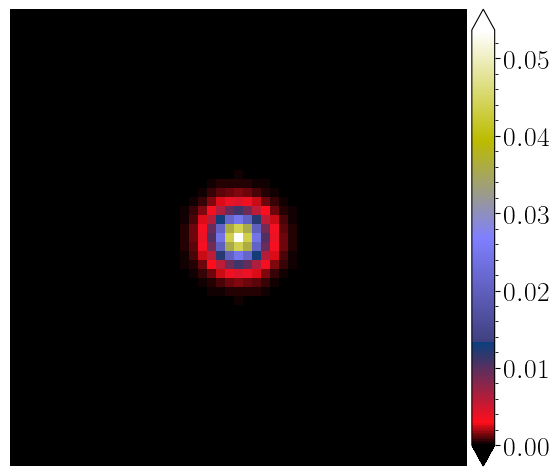

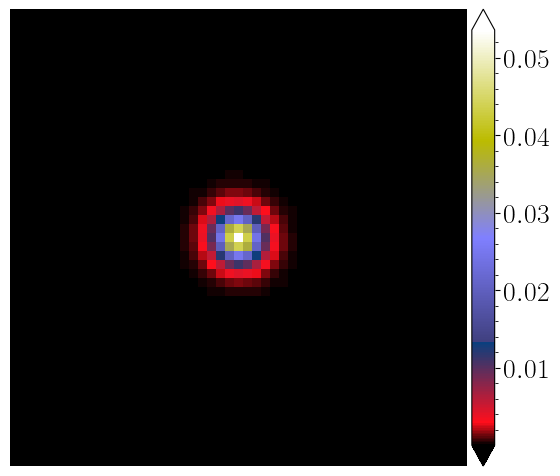

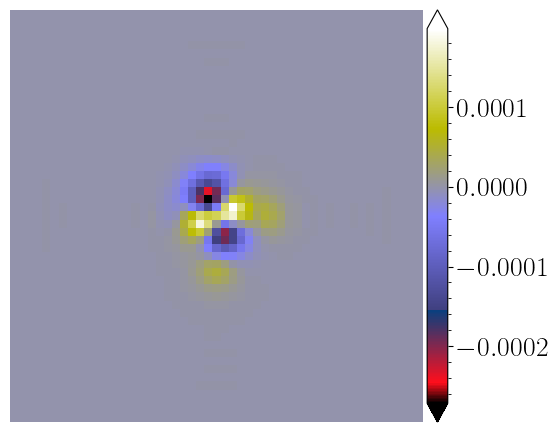

In [27]:
idx = random.randint(0,test_stars.shape[0])

plot_fun(test_stars[idx,:,:])
plot_fun(matched_PSFs[idx,:,:])
plot_fun(test_stars[idx,:,:] - matched_PSFs[idx,:,:])

